In [1]:
import gymnasium as gym
import torch
import sys

In [2]:
env = gym.make_vec('CartPole-v1', num_envs = 4)

Checking out environments

In [3]:
env.observation_space

Box([[-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]], [[4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]], (4, 4), float32)

In [4]:
obs_sample = env.observation_space.sample()
obs_sample

array([[-3.5407896 ,  1.274016  , -0.16806215, -1.7177982 ],
       [ 4.121628  , -0.21608864, -0.00991863, -1.4280933 ],
       [ 2.8774114 , -1.2473367 ,  0.18532707, -0.47520405],
       [ 0.5894439 ,  0.09570763, -0.07970697,  1.0657593 ]],
      dtype=float32)

In [5]:
obs_sample.shape

(4, 4)

In [6]:
env.action_space

MultiDiscrete([2 2 2 2])

In [7]:
actions_sample = env.action_space.sample()
actions_sample

array([1, 0, 1, 1])

In [8]:
states, info = env.reset()
states

array([[ 0.01276541,  0.0331396 , -0.01383512,  0.00921225],
       [ 0.02967813,  0.04759272,  0.04370833,  0.02221471],
       [-0.0397868 , -0.04964592, -0.04052299,  0.0244269 ],
       [-0.03911373, -0.03532823,  0.02334637, -0.04364095]],
      dtype=float32)

In [9]:
next_states, rewards, dones, terminated, _ = env.step(actions_sample)

In [10]:
next_states

array([[ 0.0134282 ,  0.22845721, -0.01365087, -0.2878035 ],
       [ 0.03062998, -0.14812791,  0.04415262,  0.32836142],
       [-0.04077972,  0.14603303, -0.04003445, -0.28076106],
       [-0.03982029,  0.1594513 ,  0.02247355, -0.3288674 ]],
      dtype=float32)

In [11]:
rewards

array([1., 1., 1., 1.], dtype=float32)

In [12]:
dones # done is when state successfully finished or passed

array([False, False, False, False])

In [13]:
# test_dones = torch.from_numpy(dones)
# for i in range(test_dones.size().numel()):
#     print(test_dones[i])

In [14]:
terminated # terminated is when agent failed 

array([False, False, False, False])

Setting up networks

In [15]:
import random
import numpy as np
from src.ppo import *

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [16]:
actor = Actor(4, 2, 256).to(device)
critic = Critic(4, 1, 256).to(device)

In [17]:
obs_sample = torch.from_numpy(obs_sample).to(device)
dist = actor.forward(obs_sample)
dist

Categorical(logits: torch.Size([4, 2]))

In [18]:
test_sample = dist.sample()

In [19]:
dist.log_prob(test_sample)

tensor([-0.4010, -0.4820, -0.8629, -0.6908], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

In [20]:
dist.log_prob(test_sample).exp()

tensor([0.6696, 0.6176, 0.4219, 0.5012], device='cuda:0',
       grad_fn=<ExpBackward0>)

In [21]:
critic.forward(obs_sample)

tensor([[-0.0585],
        [ 0.1912],
        [ 0.0420],
        [ 0.0685]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
agent = Agent(actor, critic, 0.2, 0.99, 0.8, 0.5, 0.01, 0.0003, 0.0003, device, 8)

In [23]:
train(env, agent, 800, 128, 4)

finished episode: 0
total reward: 493.0
number of steps: 128
---------------
new best model... saving...
finished episode: 1
total reward: 498.0
number of steps: 128
---------------
new best model... saving...
finished episode: 2
total reward: 487.0
number of steps: 128
---------------
finished episode: 3
total reward: 491.0
number of steps: 128
---------------
finished episode: 4
total reward: 488.0
number of steps: 128
---------------
finished episode: 5
total reward: 494.0
number of steps: 128
---------------
finished episode: 6
total reward: 497.0
number of steps: 128
---------------
finished episode: 7
total reward: 498.0
number of steps: 128
---------------
finished episode: 8
total reward: 503.0
number of steps: 128
---------------
new best model... saving...
finished episode: 9
total reward: 505.0
number of steps: 128
---------------
new best model... saving...
finished episode: 10
total reward: 502.0
number of steps: 128
---------------
finished episode: 11
total reward: 506.0

Text(0, 0.5, 'reward')

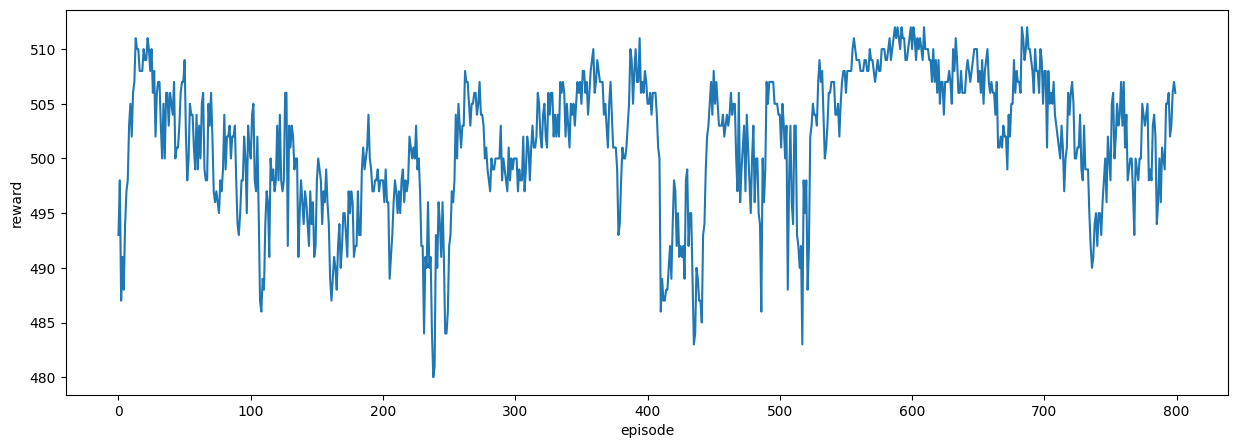

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 5))
plt.plot(agent.all_rewards)
plt.xlabel('episode')
plt.ylabel('reward')    

In [25]:
env.close()

In [ ]:
eval_env = gym.make('CartPole-v1')

eval_rewards = 0
eval_episodes = 100
for i in range(eval_episodes):
    done, truncated = False, False
    state, _ = eval_env.reset()
    total_reward = 0

    while not (done or truncated):
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            dist = actor(state_t)
            action = dist.probs.argmax(dim = 1)
            state, reward, done, truncated, _ = eval_env.step(action.item())
            total_reward += reward

    print("evaluation reward:", total_reward)
    eval_rewards += total_reward

eval_env.close()
print('average reward:', eval_rewards / eval_episodes)

evaluation reward: 131.0
evaluation reward: 398.0
evaluation reward: 199.0
evaluation reward: 196.0
evaluation reward: 354.0
evaluation reward: 188.0
evaluation reward: 101.0
evaluation reward: 500.0
evaluation reward: 196.0
evaluation reward: 218.0
evaluation reward: 500.0
evaluation reward: 225.0
evaluation reward: 243.0
evaluation reward: 171.0
evaluation reward: 128.0
evaluation reward: 318.0
evaluation reward: 218.0
evaluation reward: 197.0
evaluation reward: 241.0
evaluation reward: 233.0
evaluation reward: 230.0
evaluation reward: 334.0
evaluation reward: 188.0
evaluation reward: 500.0
evaluation reward: 162.0
evaluation reward: 257.0
evaluation reward: 155.0
evaluation reward: 211.0
evaluation reward: 283.0
evaluation reward: 164.0
evaluation reward: 500.0
evaluation reward: 250.0
evaluation reward: 335.0
evaluation reward: 185.0
evaluation reward: 217.0
evaluation reward: 162.0
evaluation reward: 273.0
evaluation reward: 202.0
evaluation reward: 250.0
evaluation reward: 260.0
